Skip the first two steps if you've already ran them and simply need to continue downloading images

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm
import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [ ]:
BASE_DIR = 'gdrive/MyDrive/geo'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
# can try using the google downloader, in which case change this to be your google api token
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'planet_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

In [ ]:
# from ctypes.util import find_library
# find_library('geos_c')
import sys
sys.path.append(BASE_DIR)
from utils import create_space

# Generate Download Locations

In [ ]:
# # df_mw = pd.read_csv(os.path.join(COUNTRIES_DIR, 'malawi_2016', 'processed/clusters.csv'))
# df_eth = pd.read_csv(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'processed/clusters.csv'))
df_ng = pd.read_csv(os.path.join(COUNTRIES_DIR, 'nigeria_2015', 'processed/clusters.csv'))

In [ ]:
for country in ['malawi_2016', 'ethiopia_2015', 'nigeria_2015']:
    os.makedirs(os.path.join(COUNTRIES_DIR, country, 'images'), exist_ok=False)

FileExistsError: ignored

In [ ]:
def generate_download_locations(df, ipc=50):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'nightlights': [] }
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['nightlights'].append(r.nightlights)
        
    return pd.DataFrame.from_dict(df_download)

In [ ]:
# # df_mw_download = generate_download_locations(df_mw)
# df_eth_download = generate_download_locations(df_eth)
df_ng_download = generate_download_locations(df_ng)

In [ ]:
# df_mw_download.shape, df_eth_download.shape, df_ng_download.shape
df_ng_download.shape

(33200, 7)

In [ ]:
# df_mw_download.head()

In [ ]:
# df_eth_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,3.410784802784024_39.47107816189403_3.45570056...,3.410785,39.471078,3.455701,39.515994,14.854634,0.0
1,3.4257567241860163_39.47107816189403_3.4557005...,3.425757,39.471078,3.455701,39.515994,14.854634,0.0
2,3.440728645588008_39.47107816189403_3.45570056...,3.440729,39.471078,3.455701,39.515994,14.854634,0.0
3,3.45570056699_39.47107816189403_3.45570056699_...,3.455701,39.471078,3.455701,39.515994,14.854634,0.0
4,3.470672488391992_39.47107816189403_3.45570056...,3.470672,39.471078,3.455701,39.515994,14.854634,0.0


In [ ]:
df_ng_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,4.270870351534024_6.223837135554024_4.31578611...,4.270870,6.223837,4.315786,6.268753,4.317717,0.123354
1,4.285842272936016_6.223837135554024_4.31578611...,4.285842,6.223837,4.315786,6.268753,4.317717,0.123354
2,4.300814194338008_6.223837135554024_4.31578611...,4.300814,6.223837,4.315786,6.268753,4.317717,0.123354
3,4.31578611574_6.223837135554024_4.31578611574_...,4.315786,6.223837,4.315786,6.268753,4.317717,0.123354
4,4.330758037141992_6.223837135554024_4.31578611...,4.330758,6.223837,4.315786,6.268753,4.317717,0.123354


In [ ]:
# # df_mw_download['country'] = 'mw'
# df_eth_download['country'] = 'eth'
df_ng_download['country'] = 'ng'

In [ ]:
# for image download purposes the country distinction is irreleveant
# df_potential_download = pd.concat([df_mw_download, df_eth_download, df_ng_download], axis=0)
df_potential_download = df_ng_download
df_potential_download.reset_index(drop=True, inplace=True)

In [ ]:
df_potential_download.head()

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights,country
0,4.270870351534024_6.223837135554024_4.31578611...,4.270870,6.223837,4.315786,6.268753,4.317717,0.123354,ng
1,4.285842272936016_6.223837135554024_4.31578611...,4.285842,6.223837,4.315786,6.268753,4.317717,0.123354,ng
2,4.300814194338008_6.223837135554024_4.31578611...,4.300814,6.223837,4.315786,6.268753,4.317717,0.123354,ng
3,4.31578611574_6.223837135554024_4.31578611574_...,4.315786,6.223837,4.315786,6.268753,4.317717,0.123354,ng
4,4.330758037141992_6.223837135554024_4.31578611...,4.330758,6.223837,4.315786,6.268753,4.317717,0.123354,ng


# Filter Download Choices

In [ ]:
df_potential_download['nightlights'].max()

67.03113555908203

In [ ]:
# most nightlights are 0
# let's download images that have nonzero nightlights to induce variety into the model
print((df_potential_download['nightlights'] == 0).mean())
print((df_potential_download['nightlights'] <= 2).mean())

0.23343373493975902
0.786144578313253


In [ ]:
def drop_0s(df, fr=0.1):
    """
        Solves for d:
            (c_z - d)/(n - d) = fr
        Where d = rows to drop, c_z = num rows with zero nightlights, n = num rows, fr = frac remaining
        
        Yields:
        d = (c_z - n*fr) / (1 - fr)
    """
    np.random.seed(RANDOM_SEED)
    c_z = (df['nightlights']==0).sum()
    n = len(df)
    assert c_z / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_z - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    zero_df = df[df['nightlights']==0]
    zero_clusters = zero_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(zero_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster with 0 nightlights')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in zero_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
    
    # this is how you do it purely randomly but some clusters might get wiped out
    # z_inds = np.argwhere(df['nightlights'].values == 0).reshape(-1)
    # drop_inds = np.random.choice(z_inds, d, replace=False)
    return df.drop(drop_inds).reset_index(drop=True)

def drop_in_range(df, lower=0, upper=2, fr=0.25):
    """
        Very similar to drop_0s calculation, but more generalized. Lower and upper are inclusive.
    """
    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['nightlights']) & (df['nightlights'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} rows in the given range')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    select_clusters = select_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(select_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster in the given range')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in select_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= MIN_IMAGES_PER_CLUSTER, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
        
    return df.drop(drop_inds).reset_index(drop=True)


In [ ]:
df_mod_download = drop_0s(df_potential_download, fr=0.1)

dropping: 4922
Need to drop 31 per cluster with 0 nightlights


In [ ]:
(df_mod_download['nightlights'] == 0).mean()

0.10371544285965839

In [ ]:
df_mod_download = drop_in_range(df_mod_download, lower=0.001, upper=3, fr=0.4)

dropping: 14153
Need to drop 35 per cluster in the given range


In [ ]:
((0.001 <= df_mod_download['nightlights']) & (df_mod_download['nightlights'] <= 3)).mean()

0.4106896551724138

In [ ]:
# this has gone up now though
(df_mod_download['nightlights'] == 0).mean()

0.20310344827586208

In [ ]:
df_mod_download = drop_0s(df_mod_download, fr=0.2)

dropping: 56
Need to drop 0 per cluster with 0 nightlights


At this point the low nightlight clusters (0 and under 3) have 11 and 12 images respectively, meaning very few more images can be dropped without going under 10.

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
X = df_mod_download['nightlights'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(df_mod_download['nightlights'].values.reshape(-1,1))

In [ ]:
(labels==0).mean(), (labels==1).mean(), (labels==2).mean()

(0.57, 0.017241379310344827, 0.4127586206896552)

In [ ]:
# these are the cutoff for the labels identified by the Guassian Mixture Model
label0_max = df_mod_download['nightlights'][labels==0].max()
label1_max = df_mod_download['nightlights'][labels==1].max()
label2_max = df_mod_download['nightlights'][labels==2].max()

label0_max, label1_max, label2_max

(16.685375213623047, 67.03113555908203, 0.04805320128798485)

In [ ]:
# I am going to hand reassign these to have better representation among all three classes
# these are not ideal distributions obviously but the model should still be able to learn
# something like a quantile cut might work better and be less arbitrary, but for reproducability 
# purposes I'll stick to the GMM-based approach
label0_max = 0.05
label1_max = 5
label2_max = 70

In [ ]:
def query_df(df, lower, upper):
    return df[((lower <= df['nightlights']) & (df['nightlights'] < upper))]

print(len(query_df(df_mod_download, 0, label0_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label0_max, label1_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label1_max, label2_max)) / len(df_mod_download))

0.41379310344827586
0.3586206896551724
0.22758620689655173


In [ ]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    labels = list(range(len(cutoffs)))[::-1]
    df['nightlights_bin'] = len(cutoffs)
    for cutoff, label in zip(cutoffs, labels):
        df['nightlights_bin'].loc[df['nightlights'] <= cutoff] = label

df_download = df_mod_download.copy()
create_nightlights_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
# these should match above
(df_download['nightlights_bin']==0).mean(), (df_download['nightlights_bin']==1).mean(), (df_download['nightlights_bin']==2).mean()


(0.41379310344827586, 0.3586206896551724, 0.22758620689655173)

In [ ]:
df_download.shape

(14500, 9)

In [ ]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

In [ ]:
df_download.to_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'), index=False)

# Download Images
If the script breaks, you can restart here by uncommenting the line below and running the below code again. It won't download images you have already downloaded.

In [ ]:
# df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [ ]:
# you can try the google downloader if you don't have the planet API key
# the tradeoff is that planet's data can be queried with time, but Google's images
# are higher res
from utils import PlanetDownloader

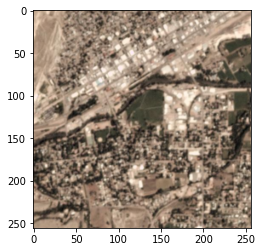

In [ ]:
# this demonstrates the API call
lat = 38.441332
lon = -105.234751
min_year = 2016
min_month = 1
max_year = 2016
max_month = 12

access = open(ACCESS_TOKEN_DIR, 'r').readlines()[0].strip()
pd = PlanetDownloader(access)
plt.imshow(pd.download_image(lat, lon, min_year, min_month, max_year, max_month))

In [ ]:
def download_images(df):
    """
    Download images using a pandas DataFrame that has "image_lat", "image_lon", "image_name", "country" as columns
    
    Saves images to the corresponding country's images folder

    To use the Google Downloader, switch PlanetDownloader to GoogleDownloader and make imd.download_image only
    provide lat and lon as arguments. Use zoom = 16.
    """
    access = None
    with open(ACCESS_TOKEN_DIR, 'r') as f:
        access = f.readlines()[0]
    imd = PlanetDownloader(access)
#     imd = GoogleDownloader(access)
    num_retries = 20
    wait_time = 0.1 # seconds

    # drops what is already downloaded
    already_downloaded = os.listdir(os.path.join(COUNTRIES_DIR, 'malawi_2016', 'images')) + \
                        os.listdir(os.path.join(COUNTRIES_DIR, 'ethiopia_2015', 'images')) + \
                        os.listdir(os.path.join(COUNTRIES_DIR, 'nigeria_2015', 'images'))
    already_downloaded =  list(set(already_downloaded).intersection(set(df['image_name'])))
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))
    # use three years of images to find one that matches search critera
    min_year = 2014
    min_month = 1
    max_year = 2016
    max_month = 12
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        lat = r.image_lat
        lon = r.image_lon
        zoom = 50
        name = r.image_name
        country_dir = None
        if r.country == 'mw':
            country_dir = 'malawi_2016'
        elif r.country == 'eth':
            country_dir = 'ethiopia_2015'
        elif r.country == 'ng':
            country_dir = 'nigeria_2015'
        else:
            print(f"unrecognized country: {r.country}")
            raise ValueError()
        image_save_path = os.path.join(COUNTRIES_DIR, country_dir, 'images', r.image_name)
        try:
            im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
            if (type(im) == str and im == 'RETRY') or im is None:
                resolved = False
                for _ in range(num_retries):
                    time.sleep(wait_time)
                    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
                    if (type(im) == str and im == 'RETRY') or im is None:
                        continue
                    else:
                        plt.imsave(image_save_path, im)
                        resolved = True
                        break
                if not resolved:
                    print(f'Could not download {lat}, {lon} despite several retries and waiting')
                    continue
                else:
                    pass
            else:
                # no issues, save according to naming convention
                plt.imsave(image_save_path, im)

        except Exception as e:
            logging.error(f"Error-could not download {lat}, {lon}", exc_info=True)
            continue

In [ ]:
download_images(df_download)

Already downloaded 0
Need to download 14500


Could not download 4.31578611574, 6.223837135554024 despite several retries and waiting
Could not download 4.330758037141992, 6.223837135554024 despite several retries and waiting
Could not download 4.285842272936016, 6.238809056956016 despite several retries and waiting
Could not download 4.345729958543984, 6.253780978358008 despite several retries and waiting
Could not download 4.300814194338008, 6.26875289976 despite several retries and waiting
Could not download 4.330758037141992, 6.26875289976 despite several retries and waiting
Could not download 4.345729958543984, 6.26875289976 despite several retries and waiting
Could not download 4.345729958543984, 6.313668663965976 despite several retries and waiting
Could not download 4.283803377034025, 6.263256104344025 despite several retries and waiting
Could not download 4.283803377034025, 6.278228025746017 despite several retries and waiting
Could not download 4.3287191412400015, 6.278228025746017 despite several retries and waiting
Cou

ERROR:root:Error-could not download 4.812296559019999, 8.176743631766016
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 46, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 4.827268480421991, 8.176743631766016 despite several retries and waiting
Could not download 4.767380794814023, 8.20668747457 despite several retries and waiting
Could not download 4.782352716216015, 8.20668747457 despite several retries and waiting
Could not download 4.797324637618007, 8.20668747457 despite several retries and waiting
Could not download 4.797324637618007, 8.221659395971992 despite several retries and waiting
Could not download 4.782352716216015, 8.236631317373984 despite several retries and waiting
Could not download 4.797324637618007, 8.236631317373984 despite several retries and waiting
Could not download 4.782352716216015, 8.251603238775976 despite several retries and waiting
Could not download 4.782409637894023, 8.052724953836012 despite several retries and waiting
Could not download 4.8123534806980075, 8.082668796639997 despite several retries and waiting
Could not download 4.8273254021, 8.082668796639997 despite several retries and waiting
Coul

ERROR:root:Error-could not download 6.485388596861992, 7.457687174016015
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 46, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 6.47041667546, 7.457687174016015 despite several retries and waiting
Could not download 6.455444754058008, 7.472659095418007 despite several retries and waiting
Could not download 6.47041667546, 7.472659095418007 despite several retries and waiting
Could not download 6.485388596861992, 7.472659095418007 despite several retries and waiting
Could not download 6.455444754058008, 7.487631016819999 despite several retries and waiting
Could not download 6.47041667546, 7.487631016819999 despite several retries and waiting
Could not download 6.485388596861992, 7.487631016819999 despite several retries and waiting
Could not download 6.500360518263984, 7.502602938221991 despite several retries and waiting
Could not download 6.431778452264023, 3.305904738064024 despite several retries and waiting
Could not download 6.446750373666015, 3.305904738064024 despite several retries and waiting
Could not download 6.461722295068007, 3.305904738064024 despite several retries and waiting


ERROR:root:Error-could not download 6.541696121215976, 3.361288400115976
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 51, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
ERROR:root:Error-could not download 6.50086128035502, 3.280458884913953
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 46, in download_images
    im = imd.dow

Could not download 6.49837750849, 3.3441339482340244 despite several retries and waiting
Could not download 6.543293272695976, 3.3441339482340244 despite several retries and waiting
Could not download 6.49837750849, 3.3591058696360165 despite several retries and waiting
Could not download 6.543293272695976, 3.3591058696360165 despite several retries and waiting
Could not download 6.453461744284024, 3.374077791038008 despite several retries and waiting
Could not download 6.49837750849, 3.374077791038008 despite several retries and waiting
Could not download 6.513349429891992, 3.374077791038008 despite several retries and waiting
Could not download 6.528321351293984, 3.374077791038008 despite several retries and waiting
Could not download 6.543293272695976, 3.374077791038008 despite several retries and waiting
Could not download 6.453461744284024, 3.3890497124400003 despite several retries and waiting
Could not download 6.468433665686016, 3.3890497124400003 despite several retries and wa

ERROR:root:Error-could not download 6.53433439066, 3.3725983755780082
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 51, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 6.549306312061992, 3.3725983755780082 despite several retries and waiting
Could not download 6.564278233463984, 3.3725983755780082 despite several retries and waiting
Could not download 6.579250154865976, 3.3725983755780082 despite several retries and waiting


ERROR:root:Error-could not download 6.4894186264540235, 3.3875702969800003
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 51, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 6.504390547856016, 3.3875702969800003 despite several retries and waiting
Could not download 6.519362469258008, 3.3875702969800003 despite several retries and waiting
Could not download 6.53433439066, 3.3875702969800003 despite several retries and waiting
Could not download 6.549306312061992, 3.3875702969800003 despite several retries and waiting
Could not download 6.564278233463984, 3.3875702969800003 despite several retries and waiting
Could not download 6.579250154865976, 3.3875702969800003 despite several retries and waiting
Could not download 6.4894186264540235, 3.4025422183819924 despite several retries and waiting
Could not download 6.504390547856016, 3.4025422183819924 despite several retries and waiting
Could not download 6.519362469258008, 3.4025422183819924 despite several retries and waiting
Could not download 6.53433439066, 3.4025422183819924 despite several retries and waiting
Could not download 6.549306312061992, 3.4025422183819924 despite several retr

ERROR:root:Error-could not download 6.761198113495976, 8.902699118784021
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 46, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Could not download 6.694550227774024, 3.025148089914024 despite several retries and waiting
Could not download 6.724494070578008, 3.025148089914024 despite several retries and waiting
Could not download 6.7544379133819925, 3.025148089914024 despite several retries and waiting
Could not download 6.769409834783985, 3.025148089914024 despite several retries and waiting
Could not download 6.709522149176016, 3.040120011316016 despite several retries and waiting
Could not download 6.724494070578008, 3.040120011316016 despite several retries and waiting
Could not download 6.73946599198, 3.07006385412 despite several retries and waiting
Could not download 6.7544379133819925, 3.085035775521992 despite several retries and waiting
Could not download 6.784381756185977, 3.1149796183259757 despite several retries and waiting
Could not download 6.73947844291, 3.136252953026016 despite several retries and waiting
Could not download 6.723021555624024, 7.633186747338008 despite several retries and waiti

ERROR:root:Error-could not download 8.445122201819999, 10.5898676009
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 46, in download_images
    im = imd.download_image(lat, lon, min_year, min_month, max_year, max_month)
  File "gdrive/MyDrive/geo/utils/planet_downloader.py", line 95, in download_image
    res = json.loads(result.text)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
ERROR:root:Error-could not download 8.430150280418006, 10.604839522301992
Traceback (most recent call last):
  File "<ipython-input-34-07c437978f2b>", line 46, in download_images
    im = imd.downl

Could not download 8.442183483694023, 4.600277017325976 despite several retries and waiting
Could not download 8.449753561004023, 4.592374400183984 despite several retries and waiting
Could not download 8.449753561004023, 4.607346321585976 despite several retries and waiting
Could not download 9.167971645683984, 8.795682521465977 despite several retries and waiting
Could not download 9.182943567085976, 8.795682521465977 despite several retries and waiting
